In [103]:
#!pip install transformers==4.12.0
#!pip install tensorflow==2.4.0
#!pip install datasets
#!pip install wandb
#!pip install langdetect

In [104]:
first_run = False

In [105]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#from google.colab import drive
from langdetect import detect
import matplotlib.dates as md

%load_ext autoreload
%autoreload 2

#drive.mount('/content/drive/')
#%cd '/content/drive/My Drive/eu_commission'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in the data

In [106]:
fs = glob.glob('data/*/*')
fields = ['text', 'lang']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
processed_tws = []
for f in fs:
    tws = json.load(open(f))['data']
    for i in range(len(tws)):
        item = {k: tws[i][k] for k in fields}
        item.update({k: tws[i]['public_metrics'][k] for k in metrics})
        item.update({'created_at': tws[i]['created_at'][:10]})
        tws[i] = item
    processed_tws += tws

In [107]:
df = pd.DataFrame(processed_tws)
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

### Tweet volume

In [ ]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_volume(language='en', freqs='D'):
    top_dict = {}
    for freq in [freqs]:
        fig, ax = plt.subplots(figsize=figsizes[freq])
        if df['created_at'].dtype != 'datetime64':
            df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
        if language=='en':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()
        else:
            new_df = df.copy()
            new_df['is_en'] = np.where(new_df[new_df['lang']=='en' & new_df['lang_detected']=='en'], 1, 0)
            grouped = new_df.groupby(pd.Grouper(key='created_at', 
                                                axis=0, 
                                                freq=freq), 
                                     'is_en').agg(lambda x: sum(x)/len(x)).reset_index()
            grouped = grouped[grouped['is_en']==0]
        top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
        grouped['smoothed'] = grouped['text'].rolling(7).mean()
        # Plot 
        sns.lineplot(data=grouped, x='created_at', y='text', 
                     alpha=.2, 
                     label='per day')
        sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                     label='smoothed avg - 7d', 
                     color=sns.color_palette()[0])
        plt.ylabel(f'Tweets per {freq_dict[freq]}')
        plt.xlabel('')
        plt.title('Tweet volume')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
        ax.xaxis.set_major_locator(md.MonthLocator())
        ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        plt.savefig('figures/tweet_volume.pdf')
        plt.show()
    return top_dict

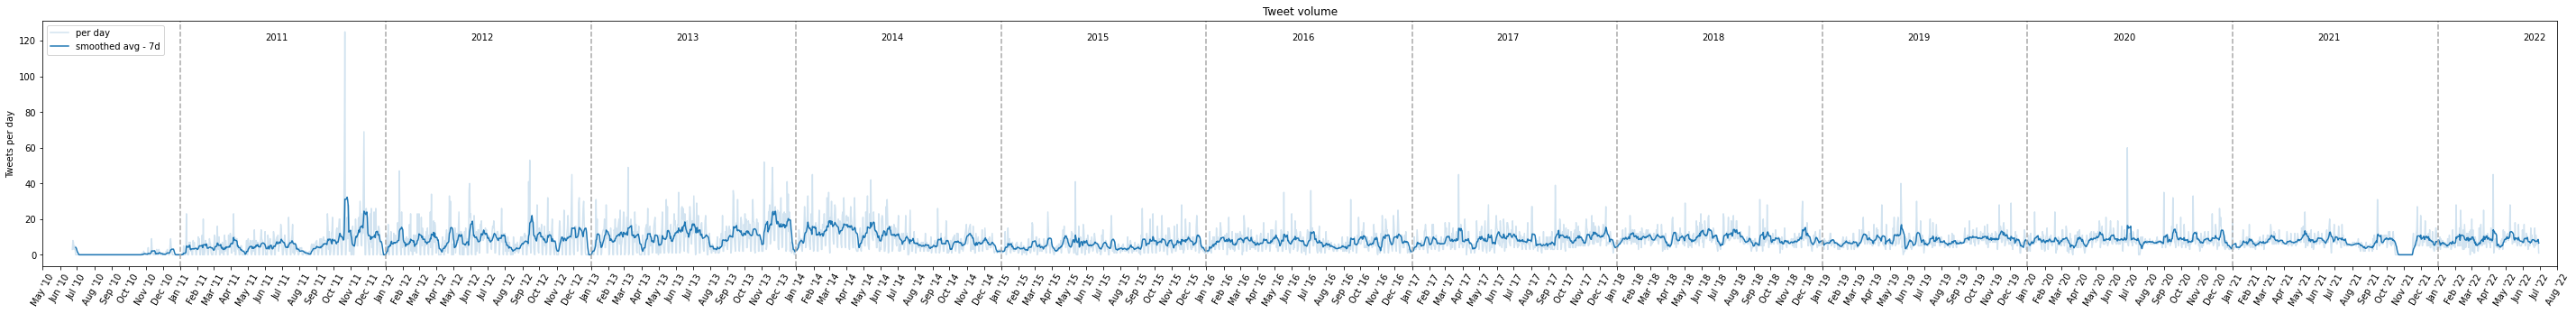

In [108]:
plot_volume()

In [109]:
print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
print(top_dict['day'][1][0])

['Air transport: #EC requests Austria, Germany, Italy and Luxembourg to comply with rules on airport charges  http://t.co/sVQ7iwfQ', 'Maritime safety:#EC requests #Italy to comply with new safety rules for passenger ships http://t.co/hMqNwrO7', 'Rail: #EC refers #Germany to Court of Justice over railway safety http://t.co/0Nfo9eAp', '#EC asks the #United Kingdom to pay due amounts of customs duties to #EU budget  http://t.co/qsjObEPR', 'Free movement of goods: #EC requests #Greece to facilitate the selling of "bake off" products  http://t.co/qH6GSk8m', 'Free movement of goods: #EC requests #Netherlands to comply with EU rules on firearms  http://t.co/3KCimGLY', "Working time: #EC requests #Belgium to end compulsory postponement of workers' annual leave http://t.co/U9GlQkPC", 'Free movement of workers: #EC requests #Italy to end discrimination in recruiting university professors  http://t.co/PFJGDfLI', 'Social Security: #EC requests #Spain to end refusal of European Health Insurance Car

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using.

In [110]:
def language_detection(s):
    try:
        return detect(s)
    except:
        return 'unk'

In [111]:
if first_run is True:
    df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
    df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
    df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
    df = df[df['text'].str.len() > 0]
    df['lang_detected'] = df['text'].apply(language_detection)
    df[df['lang']!=df['lang_detected']]
    df.to_csv('processed/all_tweets.csv', sep=',')

Breakdown of number of tweets per language

In [112]:
df = pd.read_csv('processed/all_tweets.csv', sep=',', index_col=0)
df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1)

,lang,count
9,en,32442
14,fr,828
7,de,207
10,es,155
31,und,122
19,it,81
26,ro,69
30,uk,47
24,pl,45
22,nl,37


In [ ]:
plot_volume(language='other')

Removing tweets not in English, it's mostly translations of English tweets. We know that Twitter's automatic language detection is not great, so double-checking with langdetect and only including tweets tagged as English by both the default tagger and langdetect.

In [113]:
df = df[(df['lang']=='en') & (df['lang_detected']=='en')]

### Train-test splits
Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [114]:
import random
random.seed(42)

train_size = 3000
val_size = 500

train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
random.shuffle(train_test)
df['pretraining_splits'] = train_test

Great, now let's fine tune some language models on these tweets for better performance. 

In [115]:
def _save_results(rlist):
    fname = 'logs/pretraining/performances.jsonl'
    try:
        rdf = pd.read_json(fname, 
                           orient="records",
                           lines=True)
        rdf = pd.concat([rdf, pd.DataFrame(rlist)])
    except:
        rdf = pd.DataFrame(rlist)
    rdf.to_json(fname, orient="records", lines=True)

### Training

In [ ]:
from pretrain import Pretrainer
models = ['distilbert-base-uncased',
          'distilbert-base-uncased-finetuned-sst-2-english',
          'cardiffnlp/tweet-topic-21-multi']
results = []

trainer = Pretrainer(models[-1], df, 
                      batch_size=4, 
                      lr=2e-2, 
                      warmup=batch_size)
trainer.compile()
r = trainer.fit()
results.append(r)
trainer.save(f'models/pretrained/{trainer.name}')
_save_results(results)

# Run last loop
for lr in [2e-5]: # 2e-2, 2e-6
    for batch_size in [4]: # 4
        for wu_epochs in [1]: # do 5
            for m in models:
                trainer = Pretrainer(m, df, 
                                      batch_size=batch_size, 
                                      lr=lr, 
                                      warmup=batch_size*wu_epochs)
                trainer.compile()
                r = trainer.fit()
                results.append(r)
                trainer.save(f'models/pretrained/{trainer.name}')
                _save_results(results)

Some layers from the model checkpoint at cardiffnlp/tweet-topic-21-multi were not used when initializing TFRobertaForMaskedLM: ['classifier']
- This IS expected if you are initializing TFRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForMaskedLM were not initialized from the model checkpoint at cardiffnlp/tweet-topic-21-multi and are newly initialized: ['lm_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


epoch,▁
loss,▁
val_loss,▁
best_epoch,0
best_val_loss,7.85665
epoch,0
loss,9.53097
val_loss,7.85665


57/57 [==============================] - 1s 19ms/step - loss: 14.5783


wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: too many values to unpack (expected 2)
wandb: WARNING Unable to compute FLOPs for this model.


Pre-training perplexity: 2326061.48
Epoch 1/100
509/509 [==============================] - 39s 62ms/step - loss: 9.0777 - val_loss: 7.7600
Epoch 2/100
509/509 [==============================] - 32s 62ms/step - loss: 7.7464 - val_loss: 7.6761
Epoch 3/100
509/509 [==============================] - 32s 62ms/step - loss: 7.6184 - val_loss: 7.5554
Epoch 4/100
509/509 [==============================] - 32s 62ms/step - loss: 7.5834 - val_loss: 7.6118
Epoch 5/100
509/509 [==============================] - 32s 62ms/step - loss: 7.5357 - val_loss: 7.8731
Epoch 6/100
509/509 [==============================] - 32s 62ms/step - loss: 7.5251 - val_loss: 7.6497
Epoch 7/100
509/509 [==============================] - 32s 62ms/step - loss: 7.5160 - val_loss: 7.7995
Epoch 8/100
57/57 [==============================] - 1s 19ms/step - loss: 7.9372
Post-training perplexity: 2302.62


epoch,▁▂▃▄▅▆▇█
loss,█▂▂▁▁▁▁▁
val_loss,▆▄▁▂█▃▆█
best_epoch,2
best_val_loss,7.55541
epoch,7
loss,7.47535
val_loss,7.86229


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForMaskedLM: ['activation_13']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


51/51 [==============================] - 1s 11ms/step - loss: 4.5104


wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: too many values to unpack (expected 2)
wandb: WARNING Unable to compute FLOPs for this model.


Pre-training perplexity: 91.11
Epoch 1/100
453/453 [==============================] - 19s 34ms/step - loss: 3.5800 - val_loss: 3.2243
Epoch 2/100
453/453 [==============================] - 15s 34ms/step - loss: 3.1472 - val_loss: 3.0733
Epoch 3/100
453/453 [==============================] - 15s 34ms/step - loss: 2.9085 - val_loss: 2.8719
Epoch 4/100
453/453 [==============================] - 15s 34ms/step - loss: 2.7174 - val_loss: 2.7628
Epoch 5/100
453/453 [==============================] - 15s 34ms/step - loss: 2.5728 - val_loss: 2.7271
Epoch 6/100
453/453 [==============================] - 15s 34ms/step - loss: 2.4765 - val_loss: 2.7851
Epoch 7/100
453/453 [==============================] - 15s 34ms/step - loss: 2.3483 - val_loss: 2.6056
Epoch 8/100
453/453 [==============================] - 15s 34ms/step - loss: 2.3296 - val_loss: 2.6256
Epoch 9/100
453/453 [==============================] - 15s 34ms/step - loss: 2.1867 - val_loss: 2.4487
Epoch 10/100
453/453 [====================

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▆▅▄▄▃▃▃▂▂▁▁▁▁
val_loss,█▇▅▄▄▄▂▃▁▃▁▂▂▂
best_epoch,8
best_val_loss,2.44874
epoch,13
loss,1.96678
val_loss,2.60545


Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForMaskedLM: ['classifier', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMaskedLM were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


51/51 [==============================] - 1s 11ms/step - loss: 11.4519


wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: too many values to unpack (expected 2)
wandb: WARNING Unable to compute FLOPs for this model.


Pre-training perplexity: 89220.29
Epoch 1/100
453/453 [==============================] - 19s 34ms/step - loss: 6.7090 - val_loss: 5.6683
Epoch 2/100
453/453 [==============================] - 15s 34ms/step - loss: 5.3136 - val_loss: 4.9544
Epoch 3/100
453/453 [==============================] - 15s 34ms/step - loss: 4.7349 - val_loss: 4.5498
Epoch 4/100
453/453 [==============================] - 15s 34ms/step - loss: 4.3939 - val_loss: 4.2356
Epoch 5/100
453/453 [==============================] - 15s 34ms/step - loss: 4.0524 - val_loss: 3.9859
Epoch 6/100
453/453 [==============================] - 15s 34ms/step - loss: 3.8112 - val_loss: 4.0423
Epoch 7/100
453/453 [==============================] - 15s 34ms/step - loss: 3.6695 - val_loss: 3.7834
Epoch 8/100
453/453 [==============================] - 15s 34ms/step - loss: 3.4662 - val_loss: 3.6316
Epoch 9/100
453/453 [==============================] - 15s 34ms/step - loss: 3.2985 - val_loss: 3.5602
Epoch 10/100
453/453 [=================

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁
best_epoch,27
best_val_loss,2.85629
epoch,32
loss,1.90867
val_loss,2.90731


Some layers from the model checkpoint at cardiffnlp/tweet-topic-21-multi were not used when initializing TFRobertaForMaskedLM: ['classifier']
- This IS expected if you are initializing TFRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForMaskedLM were not initialized from the model checkpoint at cardiffnlp/tweet-topic-21-multi and are newly initialized: ['lm_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


57/57 [==============================] - 1s 19ms/step - loss: 13.3237


wandb: WARNING Error initializing ValidationDataLogger in WandbCallback. Skipping logging validation data. Error: too many values to unpack (expected 2)
wandb: WARNING Unable to compute FLOPs for this model.


Pre-training perplexity: 670241.17
Epoch 1/100
509/509 [==============================] - 40s 62ms/step - loss: 7.4315 - val_loss: 5.8088
Epoch 2/100
509/509 [==============================] - 32s 62ms/step - loss: 5.4029 - val_loss: 4.8477
Epoch 3/100
509/509 [==============================] - 32s 62ms/step - loss: 4.7906 - val_loss: 4.5205
Epoch 4/100
509/509 [==============================] - 32s 62ms/step - loss: 4.3664 - val_loss: 4.1353
Epoch 5/100
509/509 [==============================] - 32s 62ms/step - loss: 4.0052 - val_loss: 4.0129
Epoch 6/100
509/509 [==============================] - 32s 62ms/step - loss: 3.7207 - val_loss: 3.7235
Epoch 7/100
509/509 [==============================] - 32s 62ms/step - loss: 3.5092 - val_loss: 3.5546
Epoch 8/100
509/509 [==============================] - 32s 62ms/step - loss: 3.3383 - val_loss: 3.3663
Epoch 9/100
509/509 [==============================] - 32s 62ms/step - loss: 3.1705 - val_loss: 3.4202
Epoch 10/100
509/509 [================

### Pretraining performance analysis

### Topic modeling
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 

In [ ]:
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence

Now, let's compare this approach with a simpler topic modeling approach.

### Next steps
- Plot performance by parameter
- Plot tweet volume by language
- Try more values for warmup (and ES)
- Set up modeling
  - Compare different approaches, with respect to sanity and fit
- Engagement as a function of topic
- Collect comments, annotate emotions in comments, plot emotion of reactions as a function of topics
    - Also polarization?
- Topics & engagement as a function of emotions of EU Commission tweet

Other:
- Decide whether to include mentions and retweets
- Streamline preprocessing